# Лекция 2. Элементарные методы анализа временных рядов

In [3]:
import pandas as pd
import numpy as np

In [4]:
sales_of_company_x = pd.read_csv("../monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("../international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("../mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("../weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("../daily-total-female-births-in-cal.csv")

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

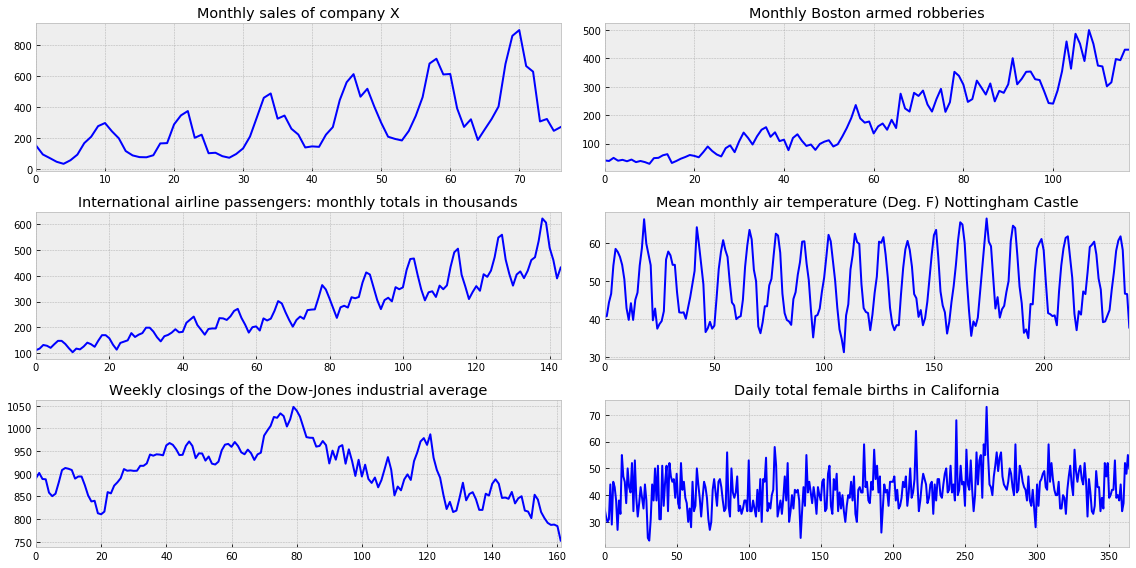

In [7]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Скользящее среднее

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо просто предсказания вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

В данном случае $\hat{y}_{t}$ называется скользящей средней

In [8]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [9]:
ser = moving_average(sales_of_company_x["Count"], 7)

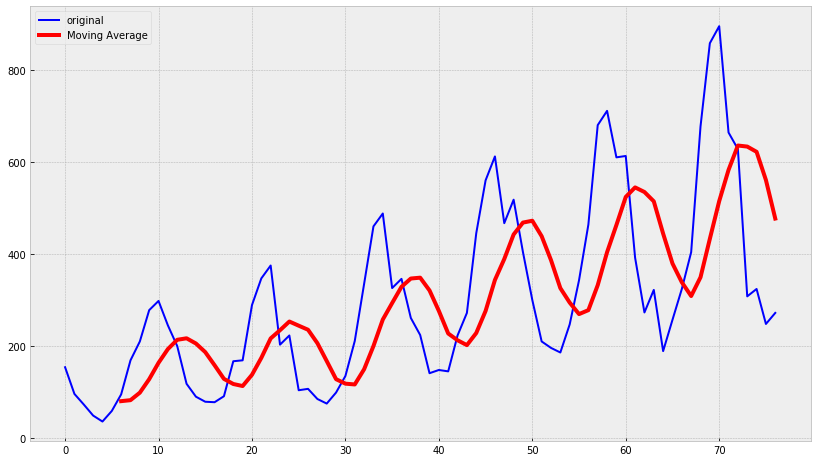

In [10]:
ser = moving_average(sales_of_company_x["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

### Практика 1. В настоящем примере функция MA просто усредняет ряд. Напишите функцию, которая предсказывает 5 следующих измерений

In [11]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [12]:
series_pred = predict(sales_of_company_x["Count"], 7, 50)

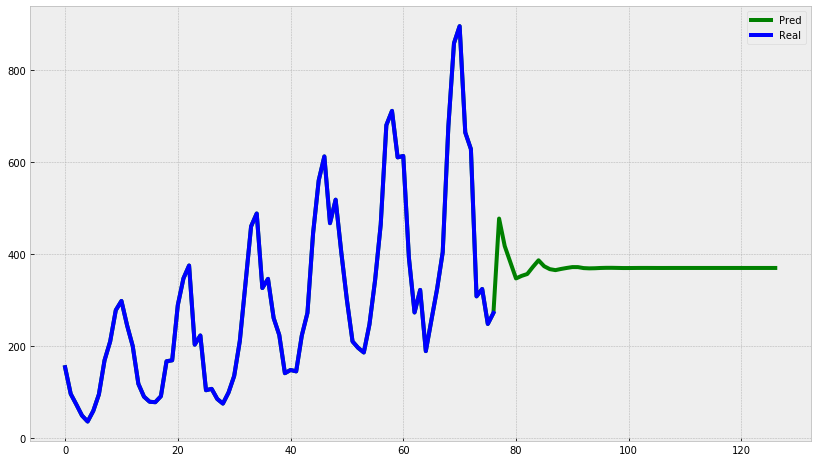

In [13]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(sales_of_company_x["Count"], color='blue', linewidth='4', label='Real')
    plt.legend()

Чем больше размер "окна" скользящего среднего $n$ тем более сглаженным получается результат. По нескольким скользящим средним можно увидеть периоды резкого роста и резкого спада.

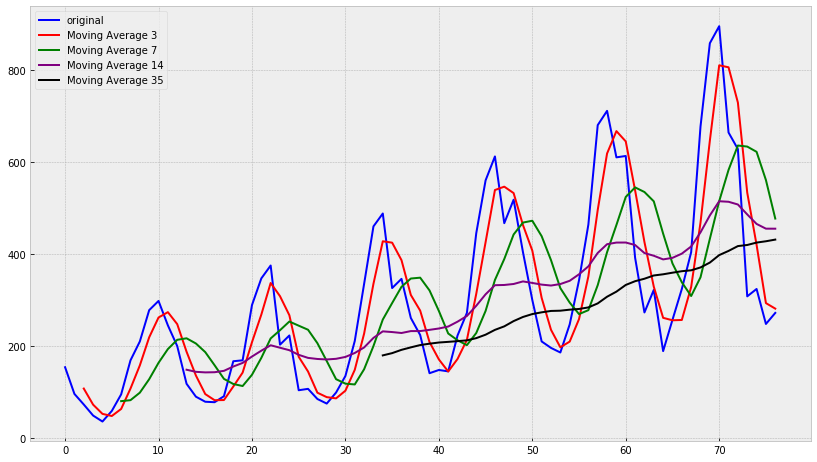

In [14]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(sales_of_company_x["Count"], windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Характерная особенность обычного скользящего среднего - повышенная чувствительность к выбросам данных

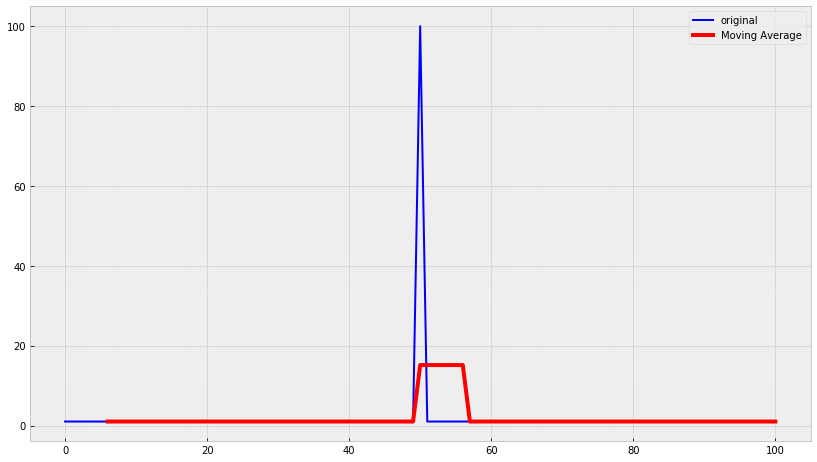

In [15]:
ts = pd.Series([1 for i in range(50)] + [100] + [1 for i in range(50)])
ser = moving_average(ts, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

В случае сильно зашумленных данных скользящее среднее помогает определить тренд

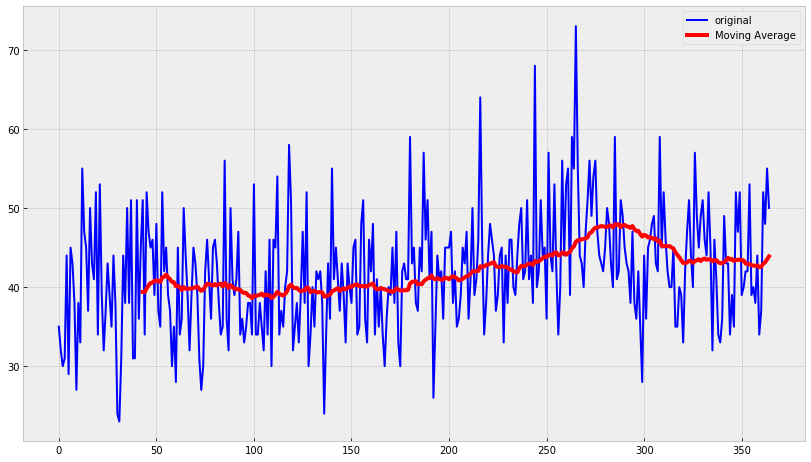

In [16]:
ts = female_births['Count']
ser = moving_average(ts, 44)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

### Практика 2. Сгенерируйте случайный шум и усредните его скользящим средним.

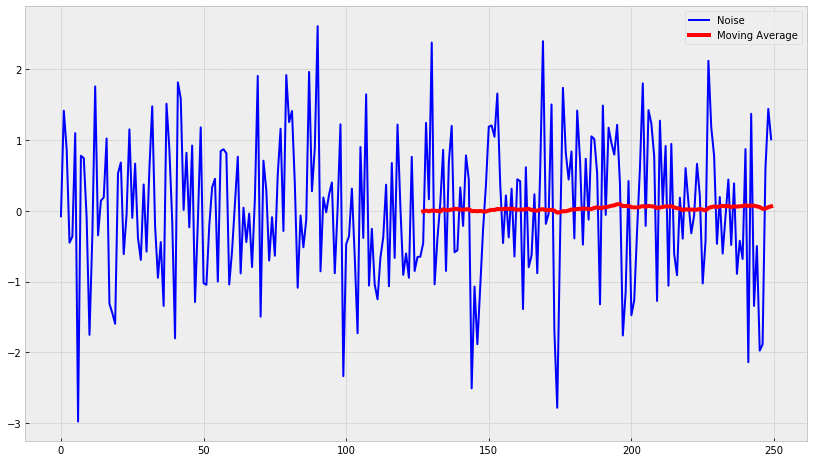

In [17]:
random_noise = pd.Series(np.random.randn(250))
ma_on_noise = moving_average(random_noise, 128)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(random_noise, color='blue',label='Noise')
    plt.plot(ma_on_noise, color='red', linewidth='4', label='Moving Average')
    plt.legend()

### Практика 3. Сгенерируйте случайный шум с трендом и усредните его скользящим средним

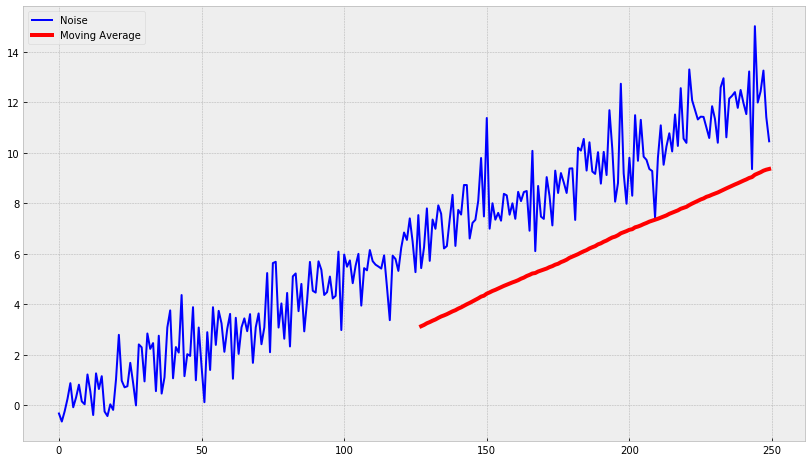

In [18]:
random_noise = np.random.randn(250)
k = 0.05
b = 0
random_noise_trend = pd.Series([k*i + b + random_noise[i] for i in range(len(random_noise))])
ma_on_noise_trend = moving_average(random_noise_trend, 128)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(random_noise_trend, color='blue',label='Noise')
    plt.plot(ma_on_noise_trend, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Модификацией обычной скользящей средней является взвешенная скользящая средняя.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

$\displaystyle\sum^{k}_{n=1} {\omega_n} = 1$

Обычно чем ближе измерение к прогнозируемому - тем больше его вес

In [19]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

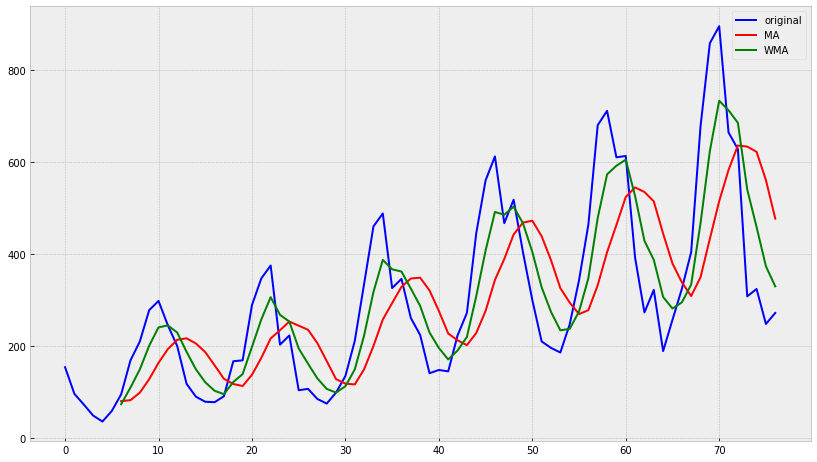

In [20]:
wma = weighted_moving_average(sales_of_company_x["Count"], 7, [1,1,2,3,5,8,13])
ma = moving_average(sales_of_company_x["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Такая вариация moving average позволяет учитывать временной контекст. Чем раньше было событие - тем меньше оно влияет на прогнозируемое событие

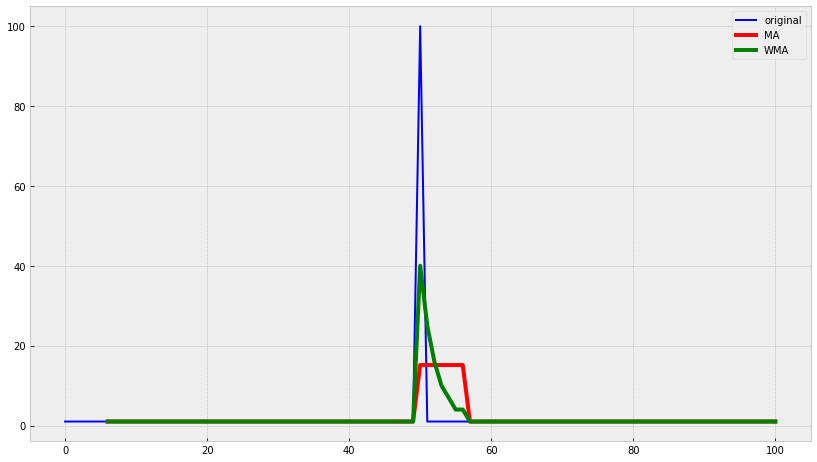

In [21]:
ts = pd.Series([1 for i in range(50)] + [100] + [1 for i in range(50)])
ma = moving_average(ts, 7)
wma = weighted_moving_average(ts, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='MA')
    plt.plot(wma, color='green', linewidth='4', label='WMA')
    plt.legend()

### Практика 4. Возьмите ряд Monthly Boston armed robberies и примените к нему wma. В качестве коэффициентов рассмотрите числа Фиббоначи, последовательные числа и степени двойки

In [22]:
series = robberies_in_boston["Count"]
wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])

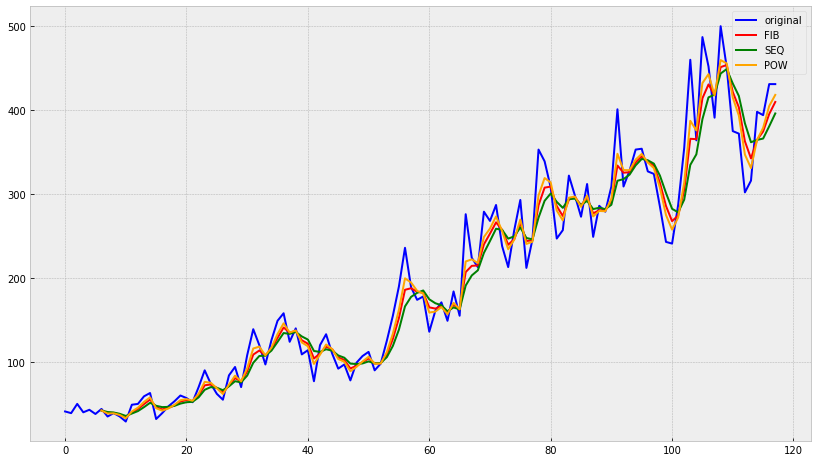

In [23]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

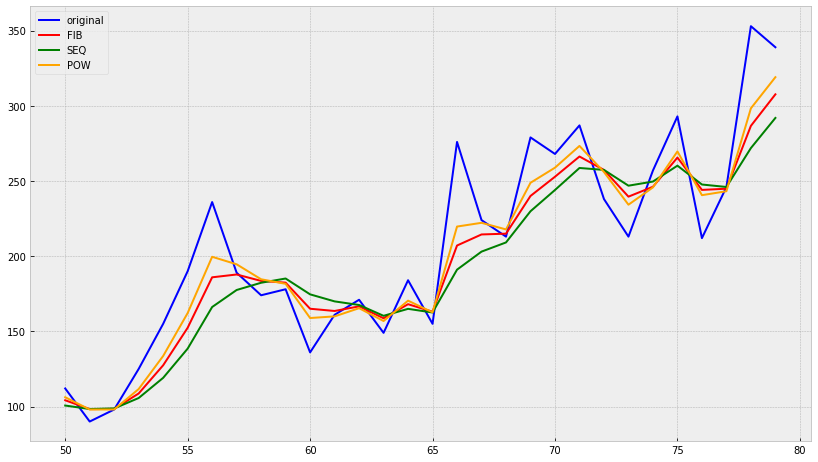

In [24]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series[50:80], color='blue',label='original')
    
    plt.plot(wma_fib[50:80], color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq[50:80], color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow[50:80], color='orange', linewidth='2', label='POW')
    plt.legend()

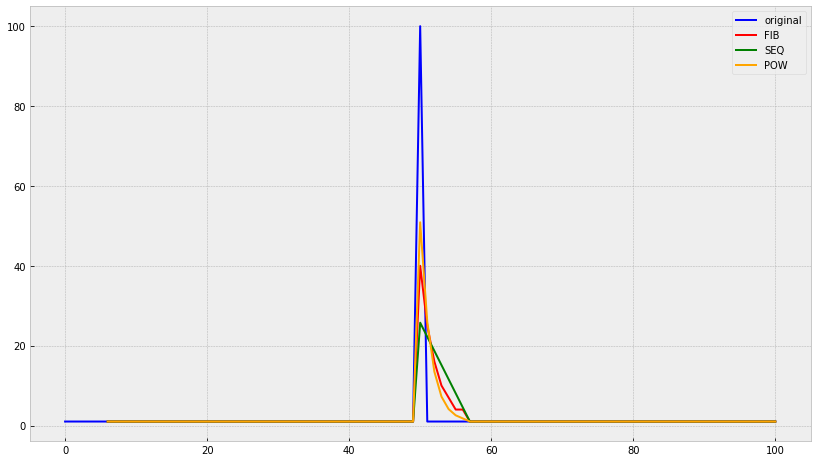

In [25]:
ts = pd.Series([1 for i in range(50)] + [100] + [1 for i in range(50)])
wma_fib = weighted_moving_average(ts, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(ts, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(ts, 7, [1,2,4,8,16,32,64])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

# Экспоненциальное сглаживание

Продолжаем развивать идею с историей. Мы хотим учитывать на самом деле учитывать не какой-то фиксированный набор измерений. В идеале - мы хотим учитывать всю историю измерений, накопившуюся к текущему моменту. Просто, как и в случае WMA, чем дальше измерение - тем меньше вклад. Для этого используется экспоненциальное скользящее среднее:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

В нем предсказанное значение - это взвешеное срденее между последним наблюдением и предыдущей историей. Легко заметить, что формула рекурсивна. Параметр $\alpha$ называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше $\alpha$, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. 

In [26]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [27]:
ema = exponential_moving_average(sales_of_company_x["Count"], 0.2)

In [28]:
len(ema)

77

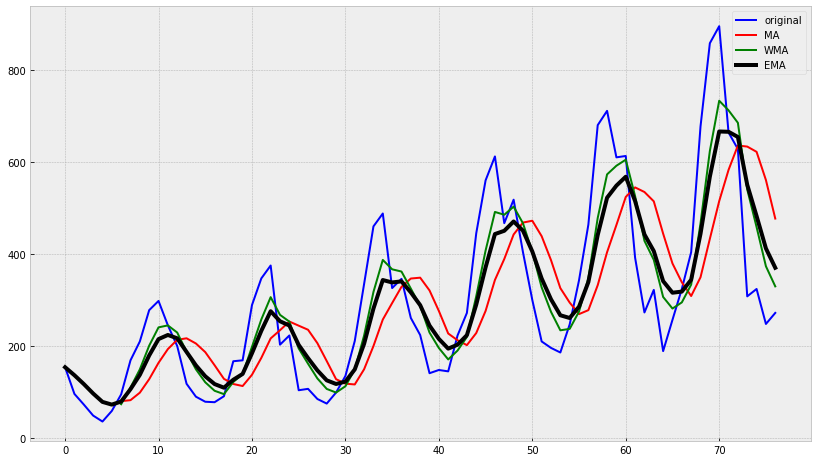

In [29]:
ema = exponential_moving_average(sales_of_company_x["Count"], 0.3)
wma = weighted_moving_average(sales_of_company_x["Count"], 7, [1,1,2,3,5,8,13])
ma = moving_average(sales_of_company_x["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

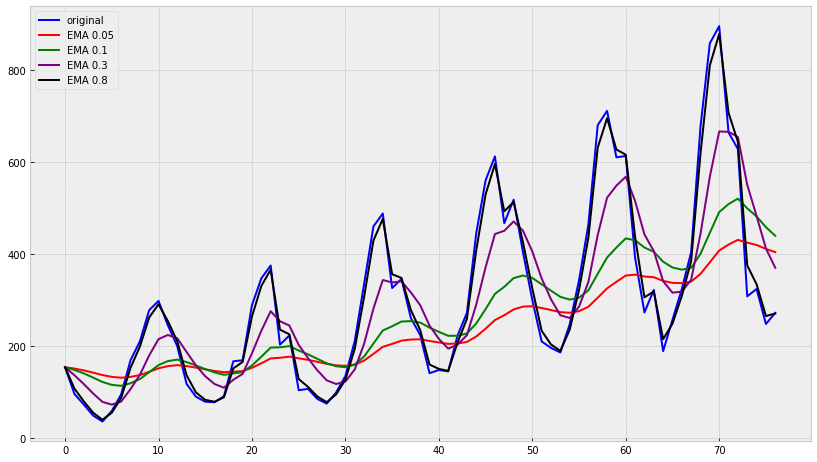

In [30]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(sales_of_company_x["Count"], alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

### Практика 5. Напишите функцию, которая предсказывает 5 наблюдений ряда на основе ema. Возьмите ряд Monthly Boston armed robberies и спрогнозируйте

In [31]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

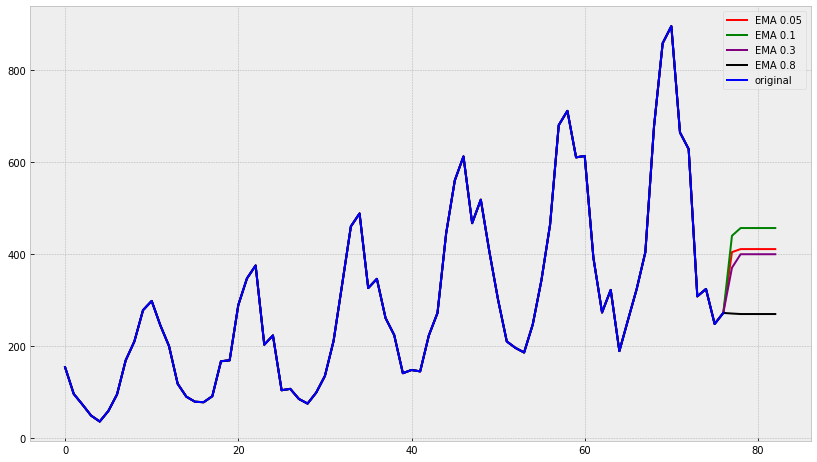

In [32]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(sales_of_company_x["Count"], alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.legend()

# Двойное экспоненциальное сглаживание

$$\hat{y}_t=l_t + s_t$$

$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$

$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$

До сих пор мы рассматривали ряд - как единую составляющую. Но на самом деле, ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [33]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [34]:
def plot_dema(alpha, beta):
    dema = double_ema(sales_of_company_x["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(sales_of_company_x["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

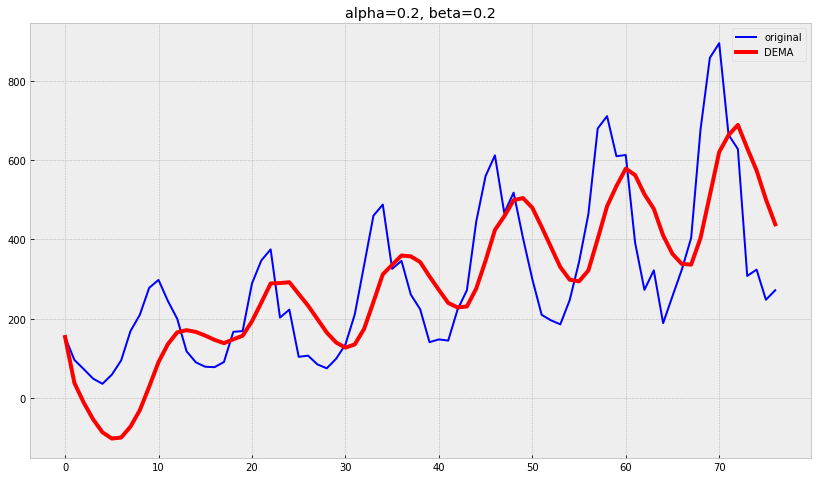

In [35]:
plot_dema(0.2, 0.2)

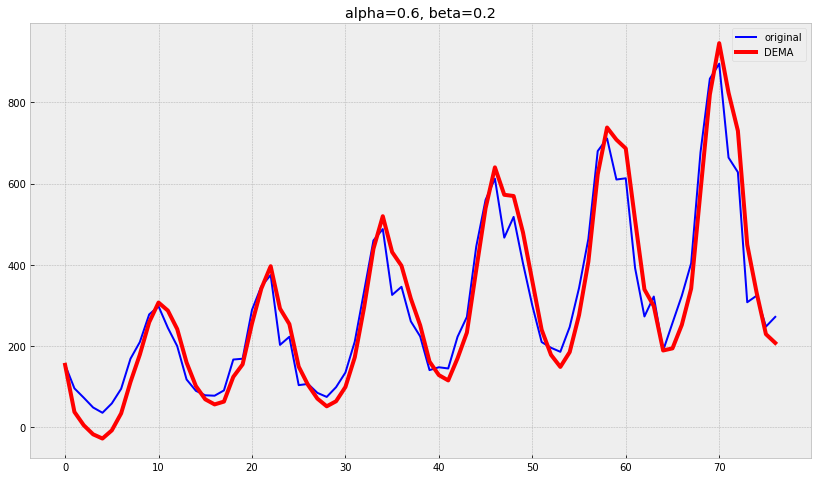

In [36]:
plot_dema(0.6, 0.2)

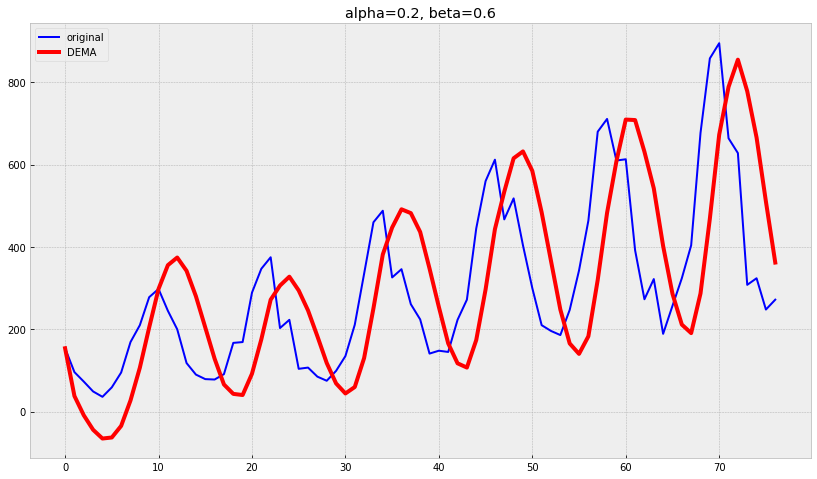

In [37]:
plot_dema(0.2, 0.6)

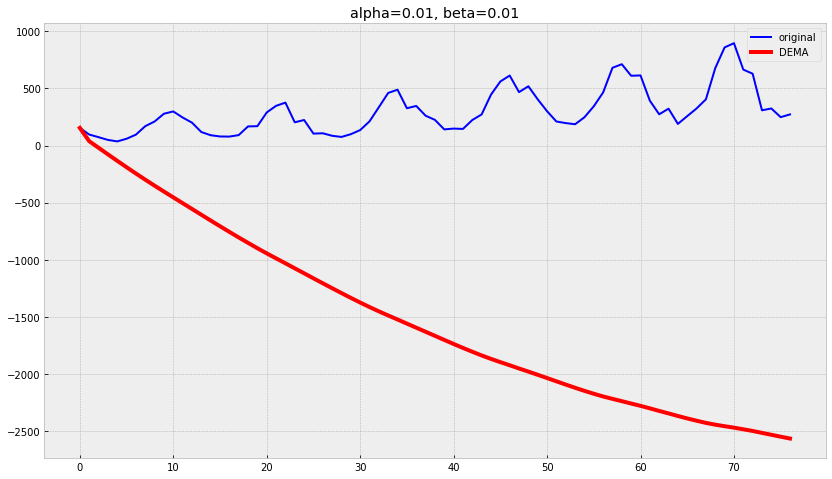

In [38]:
plot_dema(0.01, 0.01)

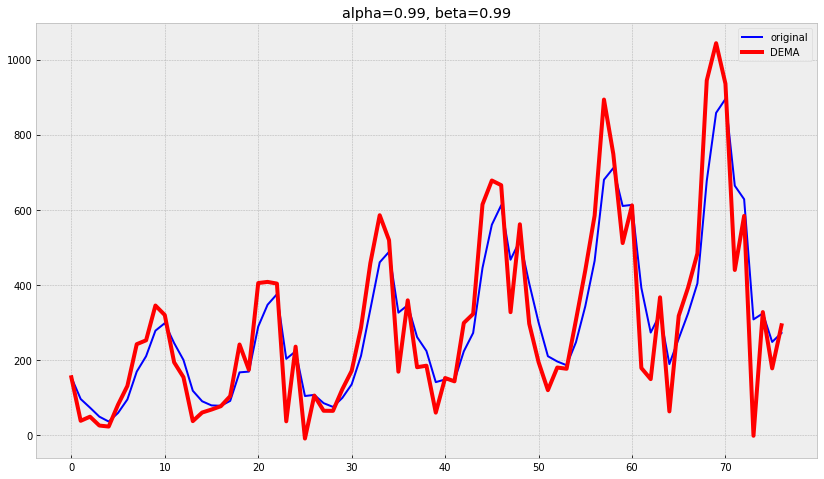

In [39]:
plot_dema(0.99, 0.99)

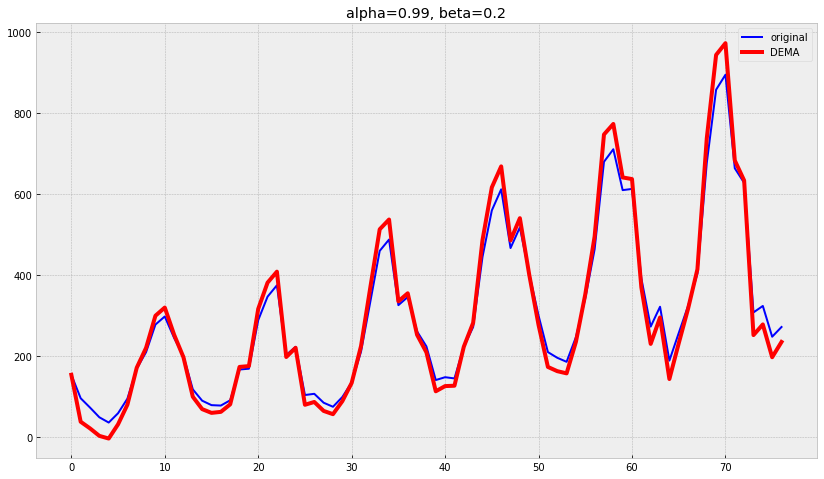

In [40]:
plot_dema(0.99, 0.2)

Как мы видим, настройка параметров $\alpha$ и $\beta$ может порой давать самые причудливые результаты. $\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.

### Практика 6. Напишите функцию, которая предсказывает 5 наблюдений ряда на основе double_ema. Возьмите ряд Monthly Boston armed robberies и спрогнозируйте

In [41]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

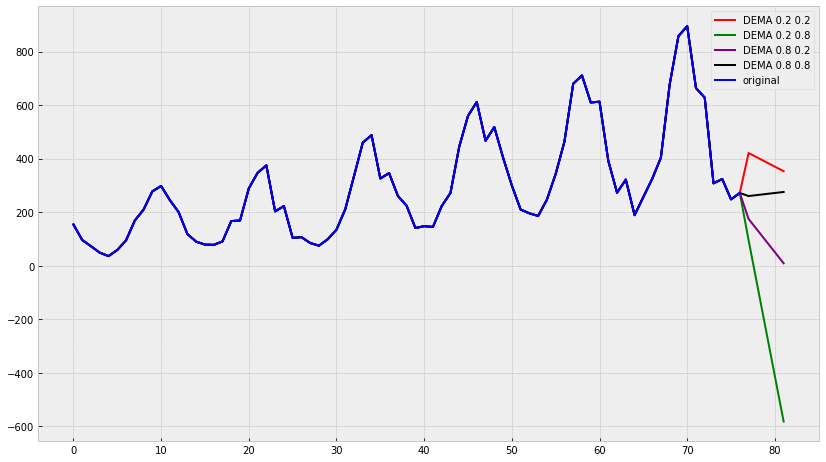

In [42]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(sales_of_company_x["Count"], alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.legend()

# Хольт-Винтерс

Суть метода в том, что начинаем еще учитывать сезонность. Она учитывается в виде третьей компоненты.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t$ объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

In [43]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [44]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [45]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [46]:
def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

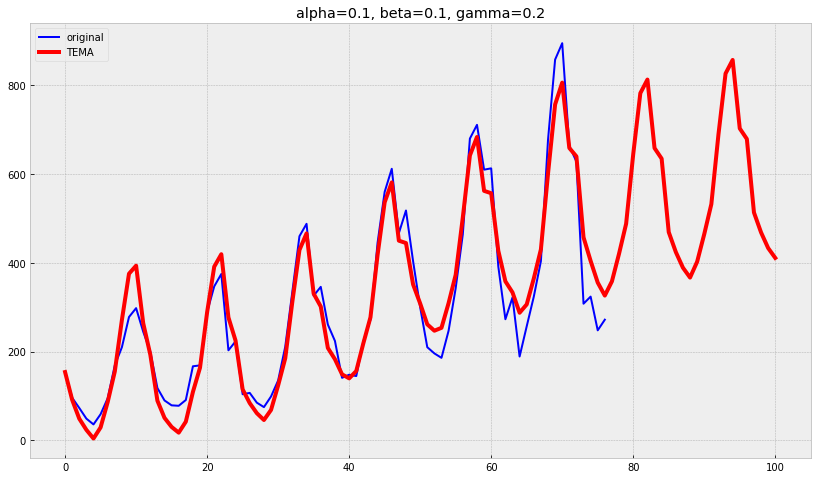

In [47]:
plot_tema(0.1, 0.1, 0.2)

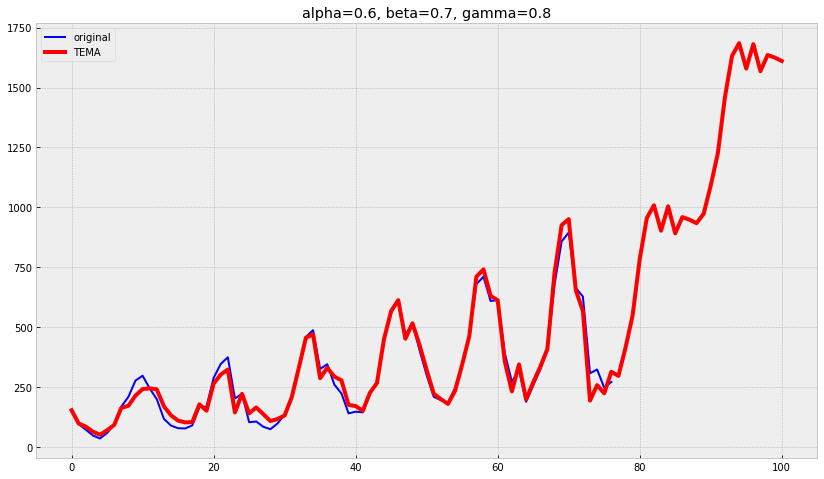

In [48]:
plot_tema(0.6, 0.7, 0.8)

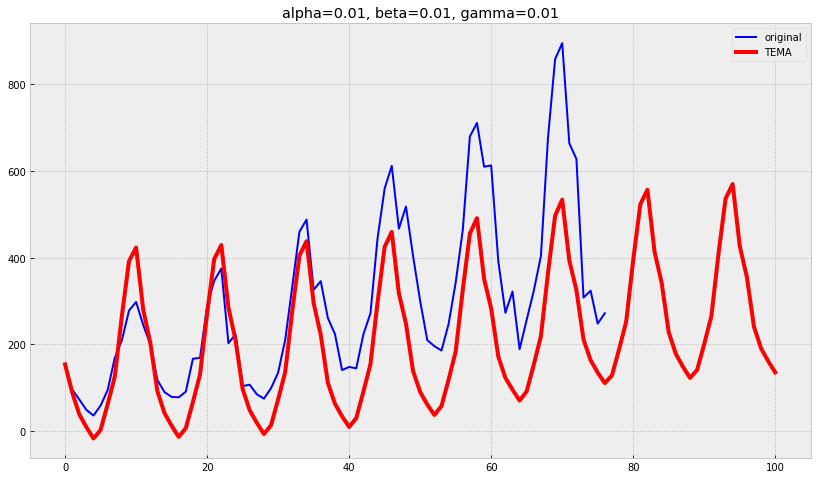

In [49]:
plot_tema(0.01, 0.01, 0.01)

# Подбор параметров

Что значит, что наша модель лучше всего приближает исходные данные? Это значит, что минимизируется некоторая функция ошибки. Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [50]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [51]:
series = sales_of_company_x["Count"]

In [52]:
train, test, val = series[:60], series[60:70], series[70:]

In [53]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [54]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [55]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4491.348161876919
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1950.29742827, 1451.00448208, 1560.13147716])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 18
   status: 0
  success: True
        x: array([0.1217733 , 0.32829139, 0.79252966])


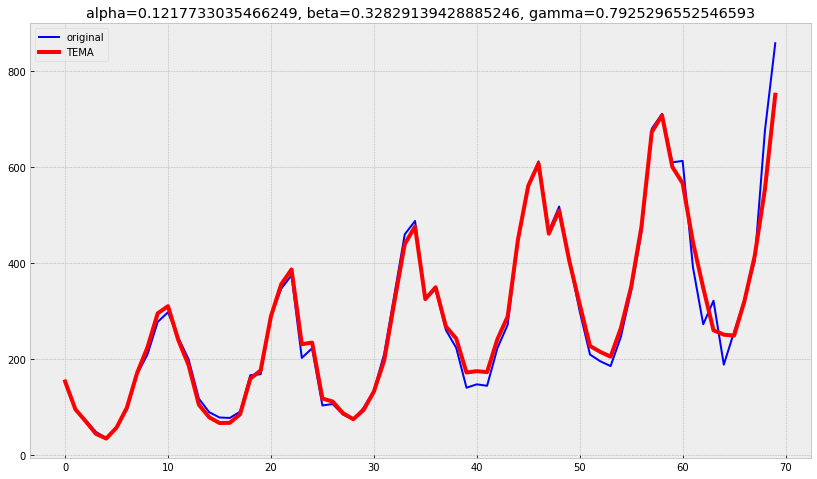

In [56]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

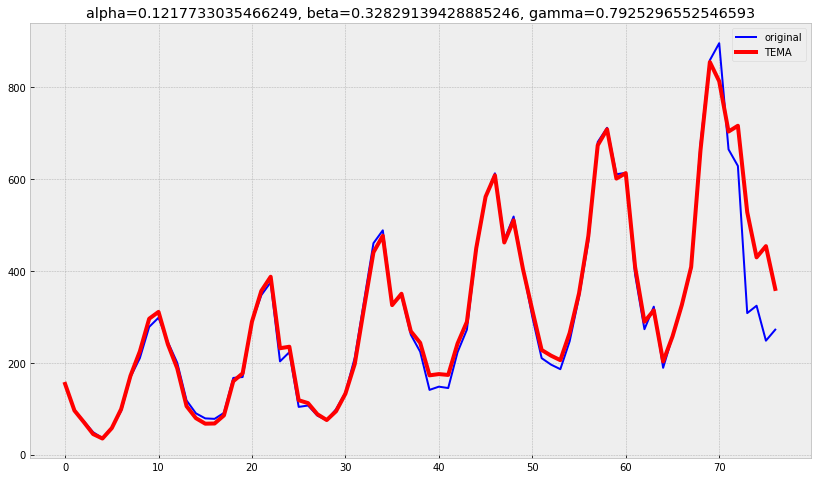

In [57]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

# Кросс-валидация

Проблема кросс-валидации на временных рядах состоит в том, что случайно перемешивать в фолдах значения всего ряда нельзя. Т.к. он имеет временную структуру, и ее надо сохранять (иначе потеряются все взаимосвязи наблюдений);

Будем делать кросс-валидацию на скользящем окне.

Суть достаточно проста:
1. Берем t измерений
2. Делаем прогноз на n измерений вперед и считаем ошибку
3. Берем t+n измерений
4. Делаем прогноз на n измерений вперед и считаем ошибку
5. Берем t+2*n измерений
6. Делаем прогноз на n измерений вперед и считаем ошибку
...

In [58]:
train, val = series[:65], series[65:]

In [67]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [68]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
33    460
34    488
35    326
36    346
37    261
38    224
39    141
40    148
41    145
42    223
43    272
44    44

Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
33    460
34    488
35    326
36    346
37    261
38    224
39    141
40    148
41    145
42

Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
33    460
34    488
35    326
36    346
37    261
38    224
39    141
40    148
41    145
42

Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
33    460
34    488
35    326
36    346
37    261
38    224
39    141
40    148
41    145
42    223
43    272
44    445
45    560
46    612
47    467
48    518
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10

Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
33    460
34    488
35    326
36    346
37    261
38    224
39    141
40    148
41    145
42    223
43    272
44    445
45    560
46    612
47    467
48    518
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26

Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10    298
11    245
12    200
13    118
14     90
15     79
16     78
17     91
18    167
19    169
20    289
21    347
22    375
23    203
24    223
25    104
26    107
27     85
28     75
29     99
30    135
31    211
32    335
33    460
34    488
35    326
36    346
37    261
38    224
39    141
40    148
41    145
42    223
43    272
44    445
45    560
46    612
47    467
48    518
Name: Count, dtype: int64
0     154
1      96
2      73
3      49
4      36
5      59
6      95
7     169
8     210
9     278
10

In [61]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.2191900337997835
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.44089210e-08, -1.66533454e-08,  4.44089210e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 228
      nit: 46
   status: 0
  success: True
        x: array([0.09054048, 0.24441134, 0.89935576])


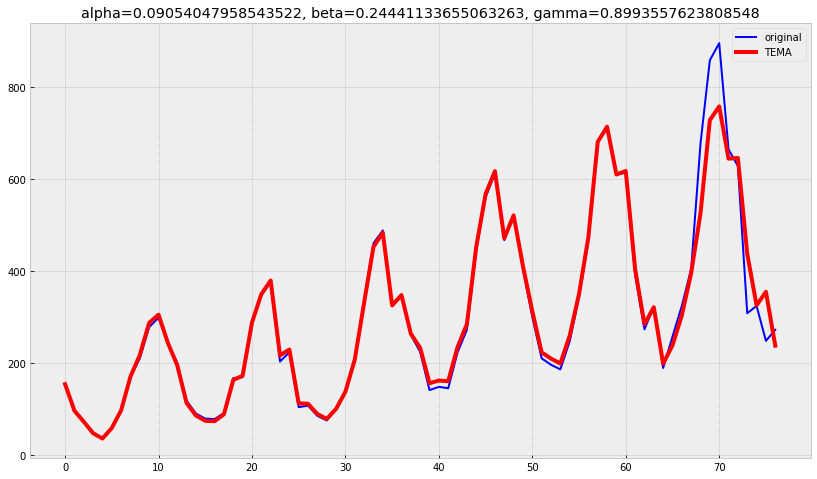

In [62]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

## Домашнее задание

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

# Дополнительно почитать

[Triple Exponential Smoothing](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm)

[Holt-Winters Forecasting for Dummies (or Developers)](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/)